# Kid-inspired Visual Analogies Challenge

[KiVA](https://ey242.github.io/kiva.github.io/) is a visual analogical reasoning benchmark designed to probe fundamental visual pattern recognition and abstraction skills in large multimodal models. The benchmark features real-world object transformations that are supported by developmental psychology and are tested to be solvable by young children as young as 3 years old. KiVA-functions for a more challenging version of the benchmark that is solvable by adults and not young children.


Github: https://github.com/ey242/KiVA

**Concepts to test:** Counting, Reflect, Resizing, Rotation

## KiVA
*   Counting: +1, +2, -1, -2
*   Reflect: along the X axis, the Y axis
*   Resizing: 0.5XY (smaller), 2XY (bigger)
*   Rotation: +90°, -90°, 180°

## KiVA Functions
*   Counting: +1, +2, -1, -2, x2, x3, d2, d3
*   Reflect: along the X axis, the Y axis
*   Resizing 0.5X (thinner), 0.5Y (shorter), 0.5XY (smaller), 2X (wider), 2Y (taller), 2XY (bigger)
*   Rotation: +45°, -45°, +90°, -90°, +135°, -135°, 180°

## KiVA Functions Compositionality
A combination of multiple KiVA Functions concepts.

## Task and Evaluation
On each trial, the model is presented with an image, a question, and four answer choices—only one of which is correct—and must select the right answer. Evaluation centers on visual extrapolation: after applying a specific transformation to a sample image, the model must choose which of three candidate transformations applied to a new image matches the original transformation.


To run on Google Colab Free, choose T4 GPU.

In [2]:
# @title Prerequisites
import PIL
import PIL.Image
from PIL import ImageOps
import os
import json
from IPython import display
from IPython.display import display
import numpy as np
from typing import Dict, Any, List, Tuple
import pandas as pd
import textwrap
import importlib
from collections import Counter
import shutil
import random

import base64
import time
import requests

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.projections import PolarAxes
from matplotlib.path import Path
from matplotlib.transforms import Affine2D
from matplotlib.projections import register_projection
from matplotlib.spines import Spine

from IPython import get_ipython

In [4]:
# @title Download & Import
# Initial Setup: fill in specifications ---
username = "kiva-admin"
data_path = "./../data/"  # all KiVA data (images and annotations) will be placed here

# Create necessary directories
os.makedirs(data_path, exist_ok=True)  # main data directory

# Load helper.py
print("Setting up helper.py...")
import importlib
import helper

importlib.reload(helper)

content_path = helper.get_content_path()
os.makedirs(os.path.join(content_path, "output"), exist_ok=True)  # helper directory

# Set up Training Data
train_trials, train_stimuli = helper.setup_kiva_data_set("train", data_path)

# Set up Validation Data
val_trials, val_stimuli = helper.setup_kiva_data_set("validation", data_path)

# remove content_path / output
shutil.rmtree(os.path.join(content_path, "output"))

# create a unit dataset, which contains 16 samples from the train set

# 1. open the train.json file
with open(os.path.join(data_path, "train.json"), "r") as f:
    train_data = json.load(f)

# 2. take first 16 trial IDs and their data, and save them to a new json file
first_16_trial_ids = list(train_data.keys())[:16]
unit_trials_dict = {trial_id: train_data[trial_id] for trial_id in first_16_trial_ids}

# Ensure the unit directory exists
os.makedirs(os.path.join(data_path, "unit"), exist_ok=True)

with open(os.path.join(data_path, "unit.json"), "w") as f:
    json.dump(unit_trials_dict, f, indent=2)

# 3. copy the first 16 images from the train set to the unit set
for trial_id in first_16_trial_ids:
    src_img = os.path.join(data_path, "train", f"{trial_id}.jpg")
    dst_img = os.path.join(data_path, "unit", f"{trial_id}.jpg")
    shutil.copy(src_img, dst_img)

print(f"Copied {len(first_16_trial_ids)} images to create the unit dataset")

print("\n--- KiVA Data Setup Complete! ---")

Setting up helper.py...

--- Setting up train data within ./../data/ ---
Loaded 2752 train trials from train.json
Found 2752 images for ../../data/train evaluation

--- Setting up validation data within ./../data/ ---
Loaded 5332 validation trials from validation.json
Found 5332 images for ../../data/validation evaluation
Copied 16 images to create the unit dataset

--- KiVA Data Setup Complete! ---


## Display Example Trial

View a random example of a training transformation along with 3 test transformation options.

On each trial, the model first sees a sample (training) transformation: two images side by side, separated by a black vertical line, showing the “before” view on the left and the transformed “after” view on the right. Beneath this, three test pairs (A, B, and C) are presented in the same format: each pair shows a new “before” image on the left and its corresponding “after” image on the right. The task is to select the one test pair whose transformation exactly matches the sample’s—i.e., the same rotation, scaling, or other visual change applied to a novel image.

Trial_id: 4933


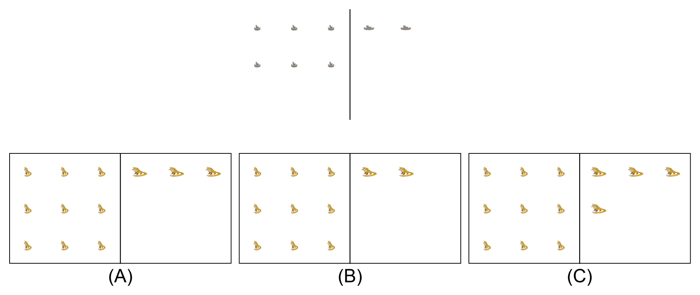


Trial Information:
level                    : kiva-functions-compositionality
transformation_domain    : Counting,Resizing
concept                  : Countingd3,Resizing2X
correct                  : (A)
incorrect1               : (C)
incorrect2               : (B)
train_object_name        : boat
test_object_name         : fox
train_input_value        : [('Resizing', ('1.2X', '1Y')), ('Counting', 6)]
train_output_value       : [('Resizing', ('2.4X', '1Y')), ('Counting', 2)]
test_input_value         : [('Resizing', ('1X', '0.8Y')), ('Counting', 9)]
correct_test_value       : [('Resizing', ('2X', '0.8Y')), ('Counting', 3)]
incorrect_test_output_value1: [('Resizing', ('2X', '0.8Y')), ('Counting', 4)]
incorrect_test_output_value2: [('Resizing', ('2X', '0.8Y')), ('Counting', 2)]


In [3]:
# @title Display Example Trial
# Specify dataset - fill in "validation" or "train"
current_eval_set = "validation"
stimuli_to_use = train_stimuli if current_eval_set == "train" else val_stimuli
trials_data_to_use = train_trials if current_eval_set == "train" else val_trials

# Show a random concept example from the selected stimuli
trial_id = helper.show_concept_example(current_eval_set, stimuli_to_use)

# Construct the correct JSON path based on current_eval_set and data_path
json_path_for_eval = os.path.join(data_path, f"{current_eval_set}.json")

# Get the trial information using the constructed JSON path
info = helper.get_trial_info(trial_id, json_path=json_path_for_eval)

if info:
    print("\nTrial Information:")
    for key, val in info.items():
        # Use textwrap to format long values for better readability
        wrapped_val = "\n".join(textwrap.wrap(str(val), width=70))
        print(f"{key:25s}: {wrapped_val}")
else:
    print(
        f"Could not find information for trial ID: {trial_id} in {json_path_for_eval}."
    )

In [4]:
# --- @title Prompting ---
# You will use this prompt to test your model on all trials.

prompt_url = "https://storage.googleapis.com/kiva-challenge/prompts.json"
resp = requests.get(prompt_url)
resp.raise_for_status()  # will error out if download fails

# 2) Parse out the two prompts
prompts = resp.json()
system_prompt = prompts["system_prompt"]
test_prompt = prompts["test_prompt"]

# 3) (Optional) Print them so people can see exactly what you’re sending to the model
print("── SYSTEM PROMPT ─────────────────────────────────────\n")
print(system_prompt, "\n")
print("── TEST PROMPT ─────────────────────────────\n")
print(test_prompt)

── SYSTEM PROMPT ─────────────────────────────────────

You are an excellent visual puzzle solver! You will be given a visual puzzle that requires using visual analogical reasoning. Each puzzle is presented as a single composite image, split into two regions:
  • A **training example** at the top: a single object shown transforming from left to right.
  • A **test panel** at the bottom: three candidate transformations of a new object, labelled (A), (B), and (C).  

Your job is:
  1. **Carefully inspect** the training example to identify exactly what changed (size, orientation, number, or a combination).
  2. **Find** which one of the three test panels applies that **same** change to the new object.
You will think step-by-step and carefully examine the visual evidence before providing an answer. 

── TEST PROMPT ─────────────────────────────

Now look at the three bottom panels, labelled (A), (B), and (C). Which one of the three left-to-right object transformations (marked by either (A)

In [5]:
# @title Fixed Categories for Evaluation
LEVEL_CATEGORIES = ["kiva", "kiva-functions", "kiva-functions-compositionality"]
TRANSFORMATION_CATEGORIES = [
    "Counting",
    "Resizing",
    "Reflect",
    "Rotation",
    "Counting,Reflect",
    "Counting,Resizing",
    "Counting,Rotation",
    "Reflect,Resizing",
    "Resizing,Rotation",
]

# transformations present in kiva and kiva-functions
TRANSFORMATIONS_FOR_SIMPLE_GROUP = ["Counting", "Resizing", "Reflect", "Rotation"]

# transformations present in kiva-functions-compositionality
TRANSFORMATIONS_FOR_COMPOSITE_GROUP = sorted(
    list(set(TRANSFORMATION_CATEGORIES) - set(TRANSFORMATIONS_FOR_SIMPLE_GROUP))
)

LEVEL_KIVA_FUNCTIONS_DB_KEY = "kiva-functions"
LEVEL_KIVA_FUNCTIONS_COMPOSITIONALITY_DB_KEY = "kiva-functions-compositionality"
LEVEL_KIVA_DB_KEY = "kiva"

In [6]:
# @title Evaluation Function
# shows how a model's ranking in the leaderboard is determined


def calc_top1(answers_list: List[Dict[str, str]], db_dict: Dict[str, Any]) -> float:
    """Calculates overall top-1 accuracy."""
    correct_count = 0
    total_count = 0
    answers_by_id = {item["id"]: item["answer"] for item in answers_list}
    for trial_id, ground_truth_info in db_dict.items():
        if trial_id in answers_by_id:
            total_count += 1
            if answers_by_id[trial_id] == ground_truth_info["correct"]:
                correct_count += 1
    return correct_count / total_count if total_count > 0 else 0.0


def calc_kiva_category_accuracies(
    answers_list: List[Dict[str, str]], db_dict: Dict[str, Any]
) -> Dict[str, float]:
    """
    Calculates accuracies based on the specified LEVEL_CATEGORIES and TRANSFORMATION_CATEGORIES,
    with specific mappings for simple and composite transformations.

    Args:
      answers_list (list): A list of dictionaries, where each dict has 'id' and 'answer'.
      db_dict (Dict): Dictionary containing the database (e.g., val_trials).

    Returns:
      Dict: A dictionary with accuracies for 'kiva-overall', level-specific overalls,
            and transformation sub-categories for 'kiva', 'kiva-functions', and 'kiva-functions-compositionality'.
    """
    results_counts = Counter()
    answers_by_id = {item["id"]: item["answer"] for item in answers_list}

    for trial_id, ground_truth_info in db_dict.items():
        if trial_id not in answers_by_id:
            continue

        predicted_answer = answers_by_id[trial_id]
        is_correct = predicted_answer == ground_truth_info["correct"]

        # 1. Update Kiva Overall Score (global accuracy across all trials)
        results_counts["kiva-overall_total"] += 1
        if is_correct:
            results_counts["kiva-overall_correct"] += 1

        trial_level = ground_truth_info.get("level")
        trial_transformation_domain = ground_truth_info.get("transformation_domain")

        # 2. Update scores for top-level categories based on the 'level' field from db_dict
        if trial_level:
            results_counts[f"{trial_level}_overall_total"] += 1
            if is_correct:
                results_counts[f"{trial_level}_overall_correct"] += 1

        # 3. Update scores for specific transformation sub-categories
        if trial_transformation_domain:
            # Simple Transformations Group: 'Counting', 'Resizing', 'Reflect', 'Rotation'
            if trial_transformation_domain in TRANSFORMATIONS_FOR_SIMPLE_GROUP:
                # This trial contributes to the general 'kiva' category for simple transformations
                # Note: This is separate from 'kiva' as a level from db_dict.
                key_kiva_simple = (
                    f"kiva_{trial_transformation_domain}"  # e.g., 'kiva_Counting'
                )
                results_counts[f"{key_kiva_simple}_total"] += 1
                if is_correct:
                    results_counts[f"{key_kiva_simple}_correct"] += 1

                # If the trial also belongs to the 'kiva-functions' level, it contributes there too
                if trial_level == LEVEL_KIVA_FUNCTIONS_DB_KEY:
                    key_kiva_functions_simple = (
                        f"{LEVEL_KIVA_FUNCTIONS_DB_KEY}_{trial_transformation_domain}"
                    )
                    results_counts[f"{key_kiva_functions_simple}_total"] += 1
                    if is_correct:
                        results_counts[f"{key_kiva_functions_simple}_correct"] += 1

            # Composite Transformations Group: e.g., 'Counting,Reflect'
            elif trial_transformation_domain in TRANSFORMATIONS_FOR_COMPOSITE_GROUP:
                # This trial contributes only if its level is 'kiva-functions-compositionality'
                if trial_level == LEVEL_KIVA_FUNCTIONS_COMPOSITIONALITY_DB_KEY:
                    key_kiva_compositionality_composite = f"{LEVEL_KIVA_FUNCTIONS_COMPOSITIONALITY_DB_KEY}_{trial_transformation_domain}"
                    results_counts[f"{key_kiva_compositionality_composite}_total"] += 1
                    if is_correct:
                        results_counts[
                            f"{key_kiva_compositionality_composite}_correct"
                        ] += 1

    # Calculate final accuracies from counts
    final_accuracies = {}

    # Overall Kiva (global accuracy)
    total = results_counts["kiva-overall_total"]
    correct = results_counts["kiva-overall_correct"]
    final_accuracies["kiva-overall"] = correct / total if total > 0 else 0.0

    # Level-specific overall accuracies (from db_dict's 'level' field)
    for level_key in [
        LEVEL_KIVA_FUNCTIONS_DB_KEY,
        LEVEL_KIVA_FUNCTIONS_COMPOSITIONALITY_DB_KEY,
        LEVEL_KIVA_DB_KEY,
    ]:
        total = results_counts[f"{level_key}_overall_total"]
        correct = results_counts[f"{level_key}_overall_correct"]
        final_accuracies[f"{level_key}_overall"] = correct / total if total > 0 else 0.0

    # Specific 'kiva' simple transformation sub-categories
    for trans_name in TRANSFORMATIONS_FOR_SIMPLE_GROUP:
        key = f"kiva_{trans_name}"
        total = results_counts[f"{key}_total"]
        correct = results_counts[f"{key}_correct"]
        final_accuracies[key] = correct / total if total > 0 else 0.0

    # 'kiva-functions' specific simple transformation sub-categories
    for trans_name in TRANSFORMATIONS_FOR_SIMPLE_GROUP:
        key = f"{LEVEL_KIVA_FUNCTIONS_DB_KEY}_{trans_name}"
        total = results_counts[f"{key}_total"]
        correct = results_counts[f"{key}_correct"]
        final_accuracies[key] = correct / total if total > 0 else 0.0

    # 'kiva-functions-compositionality' specific composite transformation sub-categories
    for trans_name in TRANSFORMATIONS_FOR_COMPOSITE_GROUP:
        key = f"{LEVEL_KIVA_FUNCTIONS_COMPOSITIONALITY_DB_KEY}_{trans_name}"
        total = results_counts[f"{key}_total"]
        correct = results_counts[f"{key}_correct"]
        final_accuracies[key] = correct / total if total > 0 else 0.0

    return dict(sorted(final_accuracies.items()))

In [7]:
# @title Frequency Baseline
class KivaFreqMCQABaseline:
    """Multiple-Choice VQA Model (Frequency Baseline).

    Attributes:
      all_train_correct_answers: List of all correct answers from the training set.
      most_frequent_overall: The single most frequent answer from the training set.
      all_possible_options: A list of all possible answer options.
    """

    def __init__(self, train_db_dict: Dict[str, Any]):
        """
        Initializes the baseline by collecting all correct answers from the
        training database for frequency-based predictions.

        Args:
            train_db_dict (Dict): The dictionary containing the training trials (e.g., train_trials).
        """
        self.all_train_correct_answers = self._collect_all_train_correct_answers(
            train_db_dict
        )
        self.most_frequent_overall = self._get_most_frequent_from_list(
            self.all_train_correct_answers
        )
        self.all_possible_options = ["(A)", "(B)", "(C)", "(D)"]

    def _collect_all_train_correct_answers(self, db_dict: Dict[str, Any]) -> List[str]:
        """
        Collects all correct answer strings from the provided database.
        """
        correct_answers = []
        for trial_info in db_dict.values():
            if "correct" in trial_info:
                correct_answers.append(trial_info["correct"])
        return correct_answers

    def _get_most_frequent_from_list(self, answer_list: List[str]) -> str:
        """
        Determines the most frequent answer from a list.
        If there's a tie, one is chosen randomly among the tied options.
        Handles empty lists by returning a random choice from all possible options.
        """
        if not answer_list:
            return random.choice(self.all_possible_options)
        counts = Counter(answer_list)
        max_freq = max(counts.values())
        most_frequent_choices = [
            ans for ans, freq in counts.items() if freq == max_freq
        ]
        return random.choice(most_frequent_choices)

    def answer_q(self, trial_info: Dict[str, Any], shots: int = -1) -> str:
        """
        Predicts an answer based on frequency from training data,
        mimicking different 'shot' settings.

        Args:
            trial_info (Dict): Dictionary containing the current trial's information.
                               (Not directly used by this baseline's logic, but kept
                                for API compatibility with other models).
            shots (int):
                - If 0: Predicts a random answer from all possible options.
                - If -1: Predicts the overall most frequent answer from all training data.
                - If > 0: Predicts the most frequent answer from a random sample of 'shots'
                          correct answers from the training data.

        Returns:
            str: The predicted answer string (e.g., '(A)').
        """
        # This parameter is for API compatibility with other models, not used by baseline logic.
        del trial_info
        assert shots >= -1

        if shots == 0:
            return random.choice(self.all_possible_options)
        elif shots == -1:
            return self.most_frequent_overall
        elif shots > 0:
            if not self.all_train_correct_answers:
                return random.choice(
                    self.all_possible_options
                )  # Fallback if no training data
            samples = random.sample(
                self.all_train_correct_answers,
                min(shots, len(self.all_train_correct_answers)),
            )
            return self._get_most_frequent_from_list(samples)
        else:  # Default or unexpected shots value
            return self.most_frequent_overall

In [8]:
# @title Evaluate Static Baseline

# Ensure val_trials is not empty before proceeding with evaluation
if not val_trials:
    print("Warning: 'val_trials' is empty. Skipping baseline evaluation.")
    results_by_shots = {}  # Ensure results_by_shots is defined even if evaluation is skipped
else:
    # Instantiate the baseline with training data (using the updated class name)
    model = KivaFreqMCQABaseline(train_trials)
    answers: List[Dict[str, str]] = []

    y_true_answers = []
    y_pred_answers = []

    # 2) Evaluate on validation data (for the initial overall accuracy print)
    for trial_id, val_trial_info in val_trials.items():
        ground_truth_correct_answer = val_trial_info["correct"]
        y_true_answers.append(ground_truth_correct_answer)

        # Baseline's prediction for this validation trial (using default shots=-1 for overall freq)
        predicted_answer = model.answer_q(val_trial_info, shots=-1)
        y_pred_answers.append(predicted_answer)

        answers.append({"id": trial_id, "answer": predicted_answer})

    # 3) Calculate overall accuracy for the single-run output
    if len(y_true_answers) > 0:
        correct_predictions_count = sum(
            1 for gt, pred in zip(y_true_answers, y_pred_answers) if gt == pred
        )
        total_predictions_count = len(y_true_answers)
        accuracy = correct_predictions_count / total_predictions_count
        print(f"KiVA Overall Frequency Baseline Accuracy on Validation: {accuracy:.1%}")
    else:
        print("No validation trials to evaluate. Accuracy cannot be calculated.")

    print("\n--- KiVA Frequency Baseline Evaluation ---")
    print(f"Baseline always predicts: {model.most_frequent_overall}")
    print(
        f"Training data correct answer frequencies: {Counter(model.all_train_correct_answers)}"
    )

    # --- Overall KiVA Frequency Baseline Evaluation by n shots---
    print("\n--- Overall KiVA Frequency Baseline Evaluation by n shots ---")
    # Evaluation settings
    test_runs = 5
    num_shots = [0, 8, -1]

    results_by_shots = {}

    for shots in num_shots:
        test_results_overall_accuracy = []

        test_results_dict_by_cat_sum = Counter()
        test_results_dict_by_cat_count = Counter()

        for run in range(test_runs):
            current_run_predictions: List[Dict[str, str]] = []

            for trial_id, val_trial_info in val_trials.items():
                predicted_answer = model.answer_q(val_trial_info, shots)
                current_run_predictions.append(
                    {"id": trial_id, "answer": predicted_answer}
                )

            top1_accuracy = calc_top1(current_run_predictions, val_trials)
            test_results_overall_accuracy.append(top1_accuracy)

            run_results_by_cat = calc_kiva_category_accuracies(
                current_run_predictions, val_trials
            )

            for cat, cat_score in run_results_by_cat.items():
                test_results_dict_by_cat_sum[cat] += cat_score
                if cat_score is not None:
                    test_results_dict_by_cat_count[cat] += 1

        mean_overall_accuracy = np.mean(test_results_overall_accuracy)
        std_overall_accuracy = np.std(test_results_overall_accuracy)

        averaged_cat_results = {}
        for cat, score_sum in test_results_dict_by_cat_sum.items():
            if test_results_dict_by_cat_count[cat] > 0:
                averaged_cat_results[cat] = (
                    score_sum / test_results_dict_by_cat_count[cat]
                )
            else:
                averaged_cat_results[cat] = 0.0

        results_by_shots[f"shots_{shots}"] = {
            "overall_mean_accuracy": mean_overall_accuracy,
            "overall_std_accuracy": std_overall_accuracy,
            "category_accuracies": averaged_cat_results,
        }

        print(
            f"Results - shots: {shots} | "
            + f"top-1 mean: {mean_overall_accuracy:.4f} | "
            + f"top-1 std: {std_overall_accuracy:.4f}"
        )

        print(
            f"Overall KiVA Score: {averaged_cat_results.get('kiva-overall', 0.0):.4f}"
        )

KiVA Overall Frequency Baseline Accuracy on Validation: 33.9%

--- KiVA Frequency Baseline Evaluation ---
Baseline always predicts: (B)
Training data correct answer frequencies: Counter({'(B)': 938, '(A)': 935, '(C)': 879})

--- Overall KiVA Frequency Baseline Evaluation by n shots ---
Results - shots: 0 | top-1 mean: 0.2528 | top-1 std: 0.0077
Overall KiVA Score: 0.2528


Results - shots: 8 | top-1 mean: 0.3341 | top-1 std: 0.0042
Overall KiVA Score: 0.3341
Results - shots: -1 | top-1 mean: 0.3393 | top-1 std: 0.0000
Overall KiVA Score: 0.3393


In [9]:
# @title Serialize Example Results File
# Writing model outputs in the expected competition format. This
# JSON file contains answers to all questions in the validation split in the
# format:
# example_submission = [{"id": "0001", "answer": "(B)"}, {"id": "0005", "answer": "(B)"}]
# This file could be used directly as a submission for the Eval.ai challenge

if answers:
    print("\n--- Serializing Results to JSON ---")
    with open("valid_results_full.json", "w") as my_file:
        json.dump(answers, my_file, indent=4)

    print(
        "File 'valid_results_full.json' created successfully with 'id' and 'answer' fields."
    )
else:
    print("\nNo answers to serialize. 'valid_results_full.json' not created.")


--- Serializing Results to JSON ---
File 'valid_results_full.json' created successfully with 'id' and 'answer' fields.


In [10]:
# @title Print Results by Category
print("\n--- Print 8-shot Frequency Results by Category ---")

if not results_by_shots:
    print("No results available to print. Evaluation was skipped or failed.")
else:
    # Get the all-shot results as a common example for detailed printing
    shot_results_key = "shots_8"
    shot_data = results_by_shots.get(shot_results_key)

    if shot_data is None:
        print(
            f"Warning: '{shot_results_key}' results not found. Please ensure 8-shot evaluation was performed."
        )
    else:
        averaged_cat_results = shot_data["category_accuracies"]

        print("\nBy Level:")
        print(
            f"  KiVA Score: {averaged_cat_results.get(LEVEL_KIVA_DB_KEY + '_overall', 0.0):.4f}"
        )
        print(
            f"  KiVA-functions Score: {averaged_cat_results.get(LEVEL_KIVA_FUNCTIONS_DB_KEY + '_overall', 0.0):.4f}"
        )
        print(
            f"  KiVA-functions-compositionality Score: {averaged_cat_results.get(LEVEL_KIVA_FUNCTIONS_COMPOSITIONALITY_DB_KEY + '_overall', 0.0):.4f}"
        )

        print("\nBy Transformation Category within Each Level:")
        print("  KiVA:")
        for trans_name in TRANSFORMATIONS_FOR_SIMPLE_GROUP:
            key = f"kiva_{trans_name}"
            print(f"    {key}: {averaged_cat_results.get(key, 0.0):.4f}")

        print("  KiVA-functions:")
        for trans_name in TRANSFORMATIONS_FOR_SIMPLE_GROUP:
            key = f"{LEVEL_KIVA_FUNCTIONS_DB_KEY}_{trans_name}"
            print(f"    {key}: {averaged_cat_results.get(key, 0.0):.4f}")

        print("  KiVA-functions-compositionality:")
        for trans_name in TRANSFORMATIONS_FOR_COMPOSITE_GROUP:
            key = f"{LEVEL_KIVA_FUNCTIONS_COMPOSITIONALITY_DB_KEY}_{trans_name}"
            print(f"    {key}: {averaged_cat_results.get(key, 0.0):.4f}")


--- Print 8-shot Frequency Results by Category ---

By Level:
  KiVA Score: 0.3372
  KiVA-functions Score: 0.3276
  KiVA-functions-compositionality Score: 0.3349

By Transformation Category within Each Level:
  KiVA:
    kiva_Counting: 0.3306
    kiva_Resizing: 0.3145
    kiva_Reflect: 0.3742
    kiva_Rotation: 0.3265
  KiVA-functions:
    kiva-functions_Counting: 0.3274
    kiva-functions_Resizing: 0.3075
    kiva-functions_Reflect: 0.3774
    kiva-functions_Rotation: 0.3309
  KiVA-functions-compositionality:
    kiva-functions-compositionality_Counting,Reflect: 0.3230
    kiva-functions-compositionality_Counting,Resizing: 0.3402
    kiva-functions-compositionality_Counting,Rotation: 0.3355
    kiva-functions-compositionality_Reflect,Resizing: 0.3258
    kiva-functions-compositionality_Resizing,Rotation: 0.3376


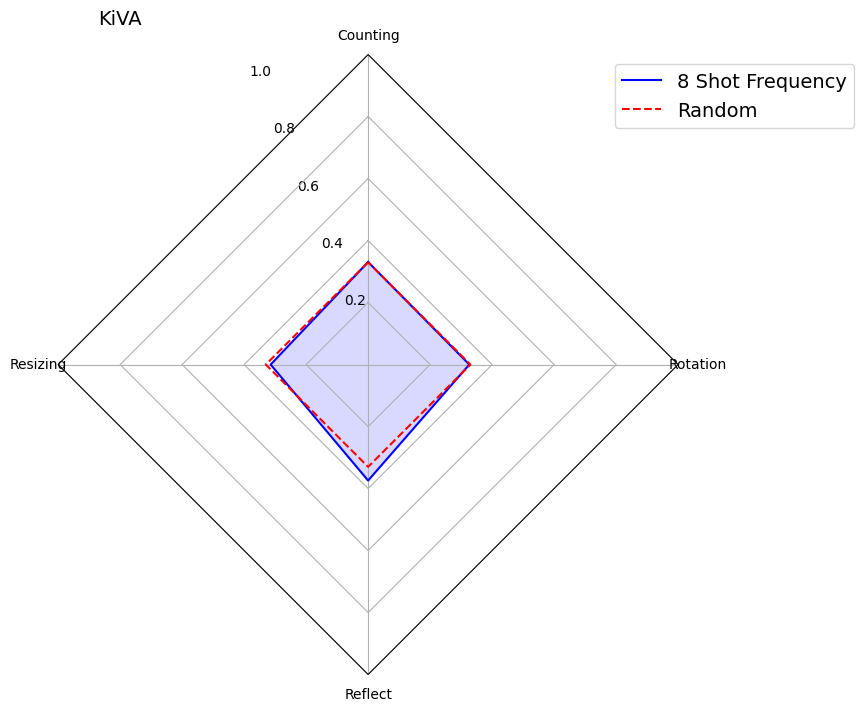

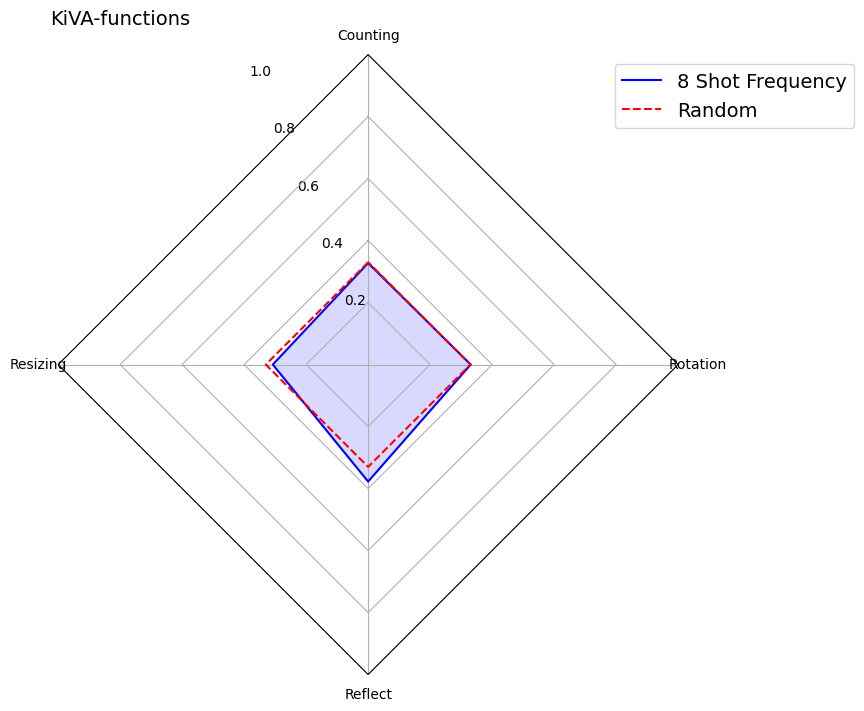

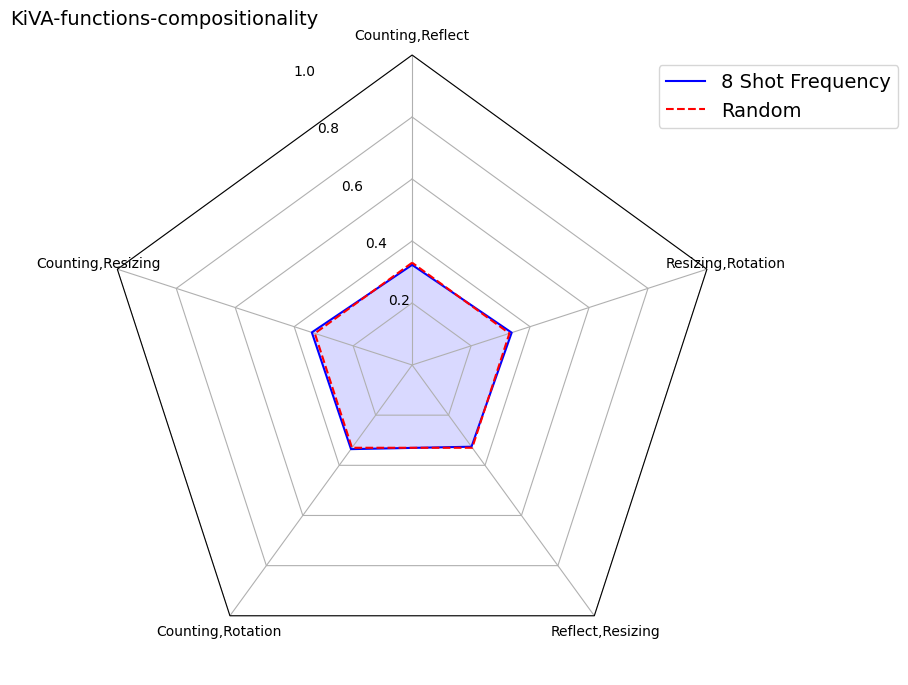

In [11]:
# @title Visualization #1: Radar Plot by Level of Difficulty
eight_shot_results = results_by_shots["shots_8"][
    "category_accuracies"
]  # plot 8-shot frequency results

if eight_shot_results:
    # --- Radar Plot for KiVA ---
    kiva_labels_radar = TRANSFORMATIONS_FOR_SIMPLE_GROUP
    kiva_scores_radar = {
        "8 Shot Frequency": [
            eight_shot_results.get(f"{LEVEL_KIVA_DB_KEY}_{trans}", 0.0)
            for trans in kiva_labels_radar
        ],
        "Random": [0.33] * len(kiva_labels_radar),  # Random fixed at 33%
    }
    helper.radar_plot_pt(
        kiva_scores_radar, kiva_labels_radar, "KiVA", ["Random"], "kiva_radar.svg"
    )

    # --- Radar Plot for KiVA-functions ---
    kiva_functions_labels_radar = TRANSFORMATIONS_FOR_SIMPLE_GROUP
    kiva_functions_scores_radar = {
        "8 Shot Frequency": [
            eight_shot_results.get(f"{LEVEL_KIVA_FUNCTIONS_DB_KEY}_{trans}", 0.0)
            for trans in kiva_functions_labels_radar
        ],
        "Random": [0.33] * len(kiva_functions_labels_radar),  # Random fixed at 33%
    }
    helper.radar_plot_pt(
        kiva_functions_scores_radar,
        kiva_functions_labels_radar,
        "KiVA-functions",
        ["Random"],
        "kiva_functions_radar.svg",
    )

    # --- Radar Plot for KiVA-functions-compositionality ---
    kiva_comp_labels_radar = TRANSFORMATIONS_FOR_COMPOSITE_GROUP
    kiva_comp_scores_radar = {
        "8 Shot Frequency": [
            eight_shot_results.get(
                f"{LEVEL_KIVA_FUNCTIONS_COMPOSITIONALITY_DB_KEY}_{trans}", 0.0
            )
            for trans in kiva_comp_labels_radar
        ],
        "Random": [0.33] * len(kiva_comp_labels_radar),  # Random fixed at 33%
    }
    helper.radar_plot_pt(
        kiva_comp_scores_radar,
        kiva_comp_labels_radar,
        "KiVA-functions-compositionality",
        ["Random"],
        "kiva_compositionality_radar.svg",
    )

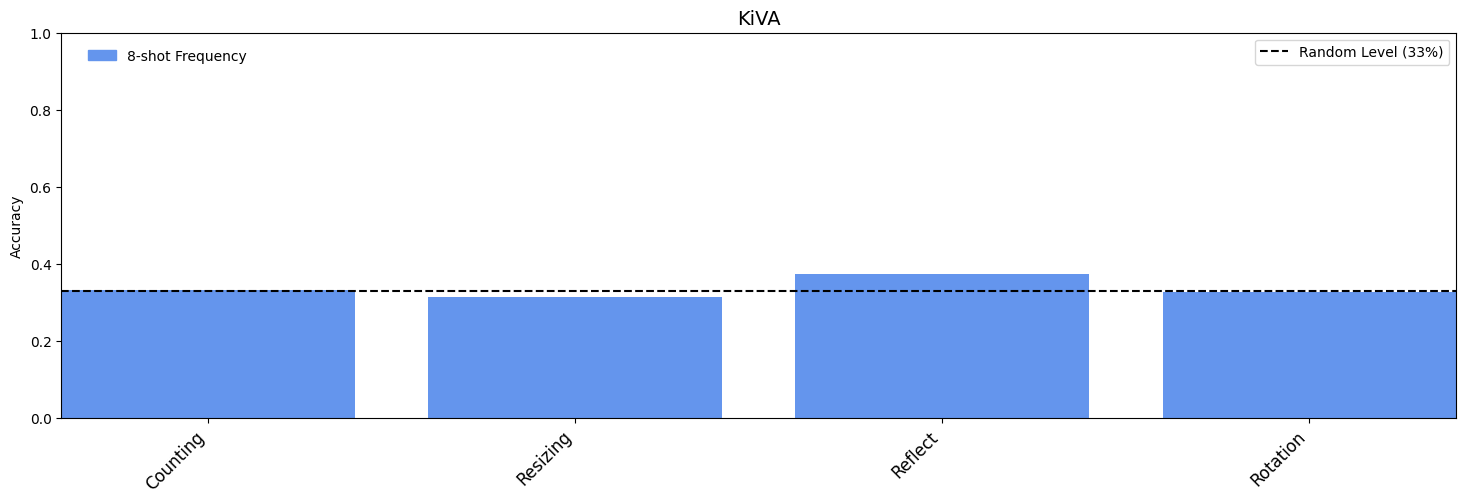

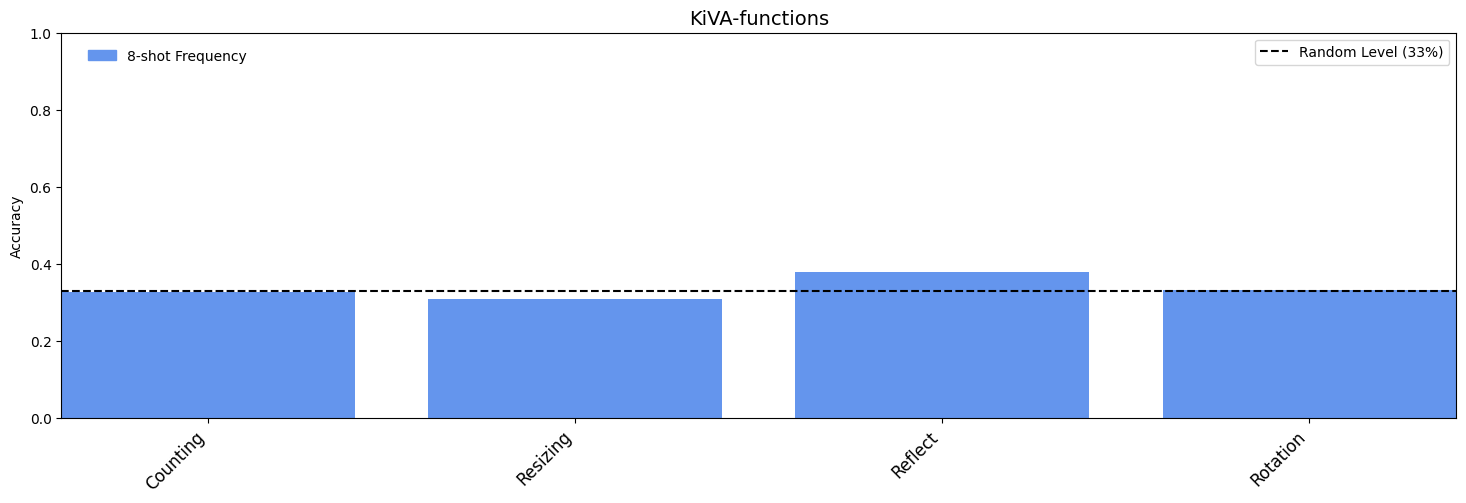

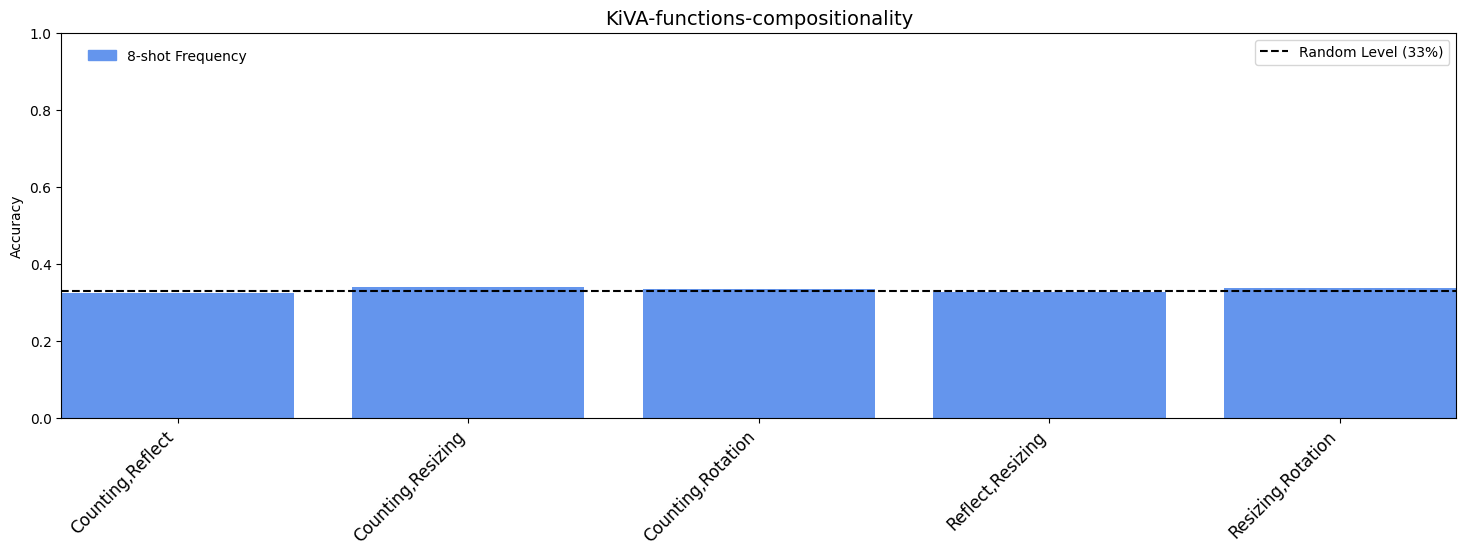

In [12]:
# @title Visualization #2: Bar Plot by Level of Difficulty
eight_shot_results = results_by_shots["shots_8"][
    "category_accuracies"
]  # plot 8-shot frequency results

if eight_shot_results:
    # --- Bar Plot for KiVA ---
    kiva_bar_exp_results = {
        trans: eight_shot_results.get(f"{LEVEL_KIVA_DB_KEY}_{trans}", 0.0)
        for trans in TRANSFORMATIONS_FOR_SIMPLE_GROUP
    }
    kiva_bar_tags_map = {
        trans: "default" for trans in TRANSFORMATIONS_FOR_SIMPLE_GROUP
    }  # Dummy tags for coloring
    helper.plot_tags(kiva_bar_exp_results, kiva_bar_tags_map, "KiVA", "kiva_bar.svg")

    # --- Bar Plot for KiVA-functions ---
    kiva_functions_bar_exp_results = {
        trans: eight_shot_results.get(f"{LEVEL_KIVA_FUNCTIONS_DB_KEY}_{trans}", 0.0)
        for trans in TRANSFORMATIONS_FOR_SIMPLE_GROUP
    }
    kiva_functions_bar_tags_map = {
        trans: "default" for trans in TRANSFORMATIONS_FOR_SIMPLE_GROUP
    }  # Dummy tags for coloring
    helper.plot_tags(
        kiva_functions_bar_exp_results,
        kiva_functions_bar_tags_map,
        "KiVA-functions",
        "kiva_functions_bar.svg",
    )

    # --- Bar Plot for KiVA-functions-compositionality ---
    kiva_comp_bar_exp_results = {
        trans: eight_shot_results.get(
            f"{LEVEL_KIVA_FUNCTIONS_COMPOSITIONALITY_DB_KEY}_{trans}", 0.0
        )
        for trans in TRANSFORMATIONS_FOR_COMPOSITE_GROUP
    }
    kiva_comp_bar_tags_map = {
        trans: "default" for trans in TRANSFORMATIONS_FOR_COMPOSITE_GROUP
    }  # Dummy tags for coloring
    helper.plot_tags(
        kiva_comp_bar_exp_results,
        kiva_comp_bar_tags_map,
        "KiVA-functions-compositionality",
        "kiva_compositionality_bar.svg",
    )

#